In [1]:
import json
import pandas as pd
import csv
from glob import glob
from tqdm import tqdm
import re
import glasbey
import seaborn as sns

In [2]:
node_pattern = "out/sab/(?P<SAB>.*)\.(?P<node_type>.+)\.nodes\.csv"

In [3]:
node_fields = {}
node_examples = {}
for filename in tqdm(glob('out/sab/*.nodes.csv')):
	node_type = re.match(node_pattern, filename).groupdict()['node_type']
	if node_type not in node_fields:
		node_fields[node_type] = set()
	with open(filename) as o:
		csv_reader = csv.reader(o)
		for row in csv_reader:
			node_fields[node_type] = node_fields[node_type].union(row[1:])
			if node_type not in node_examples:
				node_examples[node_type] = []
			if len(node_examples[node_type]) < 2:
				if row[1]!= 'label':
					node_examples[node_type].append(row[1])
			else:
				break



  0%|          | 0/84 [00:00<?, ?it/s]

100%|██████████| 84/84 [00:00<00:00, 5640.57it/s]


In [4]:
node_examples["Gene"] = ["STAT3", "MAPK1"]
node_examples["Compound"] = ["dexamethasone", "imatinib"]


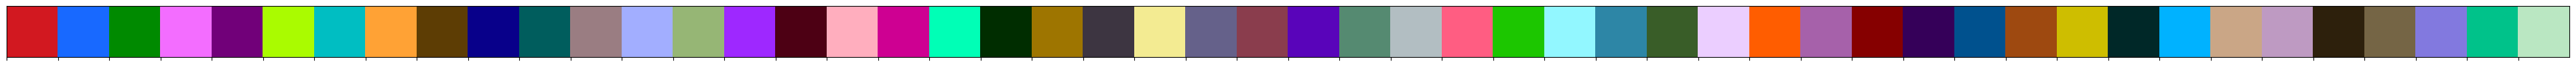

In [5]:
palette = glasbey.create_palette(palette_size=len(node_fields))
sns.palplot(palette)

In [6]:
nodes = []
for node_type, fields in node_fields.items():
	nodes.append({
		"node": node_type,
		"example": node_examples[node_type],
		"display": [{
			"label": i,
			"text": "${%s}"%i,
			"type": "text"
		} for i in node_fields[node_type]],
		"search": [i for i in node_fields[node_type] if i != "id"]
	})

In [8]:
edge_color = {
	"positively_regulates": "#E01F1F",
	"negatively_regulates": "#1FE0E0",
	"predicted_in": "#80E01F",
	"not_predicted_in": "#80E01F",
}

In [9]:
tuple([1,2])

(1, 2)

In [44]:
edge_keys = {}
for filename in tqdm(glob('out/sab/*.edges.csv')):
	df = pd.read_csv(filename, index_col=0)
	for relation in df.relation.unique():
		color = edge_color.get(relation, '#bdbdbd')
		d = df[df.relation == relation].dropna(axis=1, how='all')
		cols = tuple([color] + list(d.columns))
		if cols not in edge_keys:
			edge_keys[cols] = {
				"match": [],
				"color": color,
				"display": [{
					"label": i,
					"text": "${%s}"%i,
					"type": "text"
				} for i in cols[1:]],
			}
			
			if "evidence_class" in cols and str not in ([type(a) for a in d.evidence_class.dropna().unique()]):
				if "negative" in relation or d.evidence_class.max() < 0:
					print(relation, filename)
					edge_keys[cols]["order"] = [
						"evidence_class",
						"ASC"
					]
				else:
					edge_keys[cols]["order"] = [
						"evidence",
						"DESC"
					]
		if relation not in edge_keys[cols]["match"]: edge_keys[cols]["match"].append(relation)

 53%|█████▎    | 10/19 [00:31<00:34,  3.85s/it]

negatively_regulates out/sab/LINCS.edges.csv


100%|██████████| 19/19 [00:45<00:00,  2.40s/it]


In [45]:
edges = list(edge_keys.values())

In [46]:
edges

[{'match': ['indication',
   'has_enzyme_protein',
   'is_from_source',
   'has_glycosequence',
   'attached_by',
   'synthesized_by',
   'has_motif',
   'has_canonical_residue',
   'has_parent',
   'belongs_to_cohort',
   'has_phenotype',
   'gene_has_variants',
   'located_in',
   'p_value',
   'associated_with',
   'sex',
   'part_of',
   'regulates',
   'isa',
   'has_assay_type',
   'dataset_involves_cell_type',
   'dataset_has_file',
   'file_has_loop',
   'loop_us_start',
   'loop_us_end',
   'loop_ds_start',
   'loop_ds_end',
   'loop_has_qvalue_bin',
   'produces',
   'causally_influences',
   'correlated_with_condition',
   'has_expression',
   'molecularly_interacts_with',
   'is_subsequence_of',
   'correlated_in',
   'not_correlated_in',
   'overlaps',
   'is_part_of',
   'contributes_to_morphology_of',
   'delineates',
   'isdelineatedby',
   'has_role',
   'has_marker_gene_in_heart',
   'has_marker_gene_in_kidney',
   'has_marker_gene_in_liver',
   'has_isoform',
   'has

In [47]:
header = {
		"title": "Data Distillery KG",
		"icon": {
			"src": "https://s3.amazonaws.com/maayan-kg/cfde-kg/assets/CFDE.png",
			"favicon": "https://s3.amazonaws.com/maayan-kg/cfde-kg/assets/favicon.png",
			"faviconTitle": "Data Distillery KG",
			"alt": "Data Distillery",
			"key": "data_distillery_logo",
			"width": 100,
			"height": 100
		},
		"tabs": [
			{
				"endpoint": "/",
				"label": "Connection Explorer",
				"type": "page",
				"component": "KnowledgeGraph",
				"position": "bottom",
				"props": {
					"init_function": "initialize_kg",
					"title": "ConnectionExplorer: Find connections between CFDE DD KG entities",
					"description": "Select a CFDE DD KG entity to find other entities connected to it or explore connections between two CFDE DD KG entities.",
					"initial_query": {
						"start": "Gene",
						"start_term": "MAOB",
						"start_field": "label",
						"relation": [
							"positively_regulates"
						]
					}
				}
			},
			{
				"endpoint": "/dd_apps",
				"label": "Apps",
				"type": "group",
				"component": "DistilleryLanding",
				"position": "bottom",
				"props": {
					"title": "Data Distillery Apps",
					"description": "Explore Data Distillery data with these apps",
					"pages": [
						{
							"endpoint": "/dd_apps/tissue2drugs",
							"label": "Tissue2Drugs",
							"type": "page",
							"component": "DistilleryUseCase",
							"props": {
								"init_function": "initialize_kg",
								"title": "Tissue2Drugs",
								"description": "Find all genes that are highly expressed in a GTEx tissue and may be perturbed by a specific compound based on data from the LINCS L1000 dataset, and are known drug targets based on data curated by IDG.",
								"endpoint": "/api/distillery/tissue2drugs",
								"type": "Anatomy",
								"options_endpoint": "/api/distillery/gtex_tissue",
								"icon": "https://minio.dev.maayanlab.cloud/datadistillery-kg/img/apps/tissues2drugs.png",
								"fields": [
									"UBERON",
									"id",
									"label"
								],
								"default_term": "Subcutaneous Fat"
							}
						},
						{
							"endpoint": "/dd_apps/mw2diseases",
							"label": "MW2Disease",
							"type": "page",
							"component": "DistilleryUseCase",
							"props": {
								"init_function": "initialize_kg",
								"title": "MW2Disease",
								"description": "For a specific disease in Metabolomics Workbench, find all IDG and GTEx assertions that may be related to the disease in a specific tissue type.",
								"endpoint": "/api/distillery/mw",
								"icon": "https://minio.dev.maayanlab.cloud/datadistillery-kg/img/apps/MW2Disease.png",
								"type": "Disease or Phenotype",
								"options_endpoint": "/api/distillery/mw_diseases",
								"fields": [
									"DOID",
									"id",
									"label",
									"MONDO",
									"ORPHANET",
									"HP"
								],
								"default_term": "glutathione synthetase deficiency"
							}
						},
						{
							"endpoint": "/dd_apps/enzymeminer",
							"label": "EnzymeMiner",
							"type": "page",
							"component": "DistilleryUseCase",
							"props": {
								"init_function": "initialize_kg",
								"relations": [
									{
										"name": "positively_regulates",
										"end": "Compound"
									},
									{
										"name": "negatively_regulates",
										"end": "Compound"
									},
									{
										"name": "expressed_i"
									}
								],
								"title": "EnzymeMiner",
								"icon": "https://minio.dev.maayanlab.cloud/datadistillery-kg/img/apps/EnzymeMiner.png",
								"description": "Select a drug processing enzyme to view drugs that up or down regulate it from LINCS as well as tissues where it is highly expressed based on data from GTEx.",
								"endpoint": "/api/knowledge_graph",
								"type": "Enzyme",
								"options_endpoint": "/api/knowledge_graph/node_search",
								"fields": [
									"ENTREZ",
									"UNIPROTKB",
									"label",
									"HGNC"
								],
								"default_term": "MAOB",
								"filter_text": "Enzyme"
							}
						},
						{
							"endpoint": "/dd_apps/disease2exrna",
							"label": "Liquid Biopsy of Condition",
							"type": "page",
							"component": "DistilleryUseCase",
							"props": {
								"init_function": "initialize_kg",
								"title": "Liquid Biopsy of Condition",
								"icon": "https://minio.dev.maayanlab.cloud/datadistillery-kg/img/apps/disease2exrna.png",
								"description": "For a given set of genes that are highly expressed in a specific disease, identify extracellular RNAs (exRNAs) that may be detected in human biofluids and thus serve as non-invasive disease biomarkers.",
								"endpoint": "/api/distillery/disease2exrna",
								"type": "Disease or Phenotype",
								"options_endpoint": "/api/distillery/exrnadisease",
								"fields": [
									"DOID",
									"id",
									"label",
									"MONDO",
									"ORPHANET",
									"HP"
								],
								"default_term": "leukodystrophy"
							}
						},
						{
							"endpoint": "/dd_apps/drug2exrna",
							"label": "Liquid Biopsy of Drug Response",
							"type": "page",
							"component": "DistilleryUseCase",
							"props": {
								"init_function": "initialize_kg",
								"title": "Liquid Biopsy of Drug Response",
								"icon": "https://minio.dev.maayanlab.cloud/datadistillery-kg/img/apps/drug2exrna.png",
								"description": "For a given drug term, return (1) up-regulated genes, (2) loci expressed in exRNA that overlap RBP binding regions, (3) the RBP that overlaps the locus, and (4) the biofluid(s) where locus was expressed in exRNA.",
								"endpoint": "/api/distillery/drug2exrna",
								"type": "Compound",
								"options_endpoint": "/api/distillery/exrnadrug",
								"fields": [
									"PUBCHEM",
									"id",
									"label"
								],
								"default_term": "STK-674938"
							}
						}
					]
				}
			},
			{
				"endpoint": "/use_cases",
				"label": "Use Cases",
				"type": "group",
				"component": "DistilleryLanding",
				"position": "bottom",
				"props": {
					"title": "Data Distillery Use Case",
					"description": "Explore use cases that use distilled data from Common Fund Programs",
					"pages": [
						{
							"endpoint": "/use_cases/tissue2drugs",
							"label": "Breast Epithelium Use Case",
							"type": "page",
							"component": "DistilleryUseCase",
							"props": {
								"init_function": "initialize_kg",
								"icon": "https://minio.dev.maayanlab.cloud/datadistillery-kg/img/apps/use-case1.png",
								"title": "Breast Epitheliumn Use Case",
								"description": "Find the genes that are highly expressed in breast epithelium as well as drugs that target these genes.",
								"endpoint": "/api/distillery/tissue2drugs",
								"type": "Anatomy",
								"options_endpoint": "/api/distillery/gtex_tissue",
								"fields": [
									"UBERON",
									"id",
									"label"
								],
								"default_term": "breast epithelium"
							}
						},
						{
							"endpoint": "/use_cases/mw_diseases",
							"label": "Mild Cognitive Impairment Use Case",
							"type": "page",
							"component": "DistilleryUseCase",
							"props": {
								"init_function": "initialize_kg",
								"title": "Mild Cognitive Impairment Use Case",
								"icon": "https://minio.dev.maayanlab.cloud/datadistillery-kg/img/apps/use-case2.png",
								"width": 130,
								"height": 130,
								"description": "Find all IDG and GTEx assertions that may be related to mild cognitive impairment and any tissue type.",
								"endpoint": "/api/distillery/mw",
								"type": "Disease or Phenotype",
								"options_endpoint": "/api/distillery/mw_diseases",
								"fields": [
									"DOID",
									"id",
									"label",
									"MONDO",
									"ORPHANET",
									"HP"
								],
								"default_term": "mild cognitive impairment"
							}
						},
						{
							"endpoint": "/use_cases/enzyminer",
							"label": "CES1 Use Case",
							"type": "page",
							"component": "DistilleryUseCase",
							"props": {
								"init_function": "initialize_kg",
								"relations": [
									{
										"name": "positively regulates",
										"end": "Drug"
									},
									{
										"name": "negatively regulates",
										"end": "Drug"
									},
									{
										"name": "expresses"
									}
								],
								"title": "CES1 Use Case",
								"description": "Display drugs that up or down regulate the gene CES1 from LINCS as well as tissues where it is highly expressed based on assertions from GTEx.",
								"endpoint": "/api/knowledge_graph",
								"icon": "https://minio.dev.maayanlab.cloud/datadistillery-kg/img/apps/use-case3.png",
								"type": "Enzyme",
								"options_endpoint": "/api/knowledge_graph/node_search",
								"fields": [
									"ENTREZ",
									"UNIPROTKB",
									"label",
									"HGNC"
								],
								"default_term": "CES1"
							}
						},
						{
							"endpoint": "/use_cases/disease2exrna",
							"label": "Frontotemporal Dementia Use Case",
							"type": "page",
							"component": "DistilleryUseCase",
							"props": {
								"init_function": "initialize_kg",
								"title": "Frontotemporal Dementia Use Case",
								"icon": "https://minio.dev.maayanlab.cloud/datadistillery-kg/img/apps/dementiabiopsy.png",
								"description": "For genes that are correlated with frontotemporal dementia, identify extracellular RNAs (exRNAs) that may be detected in human biofluids and thus serve as non-invasive disease biomarkers.",
								"endpoint": "/api/distillery/disease2exrna",
								"type": "Disease or Phenotype",
								"options_endpoint": "/api/distillery/exrnadisease",
								"fields": [
									"DOID",
									"id",
									"label",
									"MONDO",
									"ORPHANET",
									"HP"
								],
								"default_term": "Frontotemporal dementia"
							}
						},
						{
							"endpoint": "/use_cases/drug2exrna",
							"label": "Liquid Biopsy of Dexamethasone Response",
							"type": "page",
							"component": "DistilleryUseCase",
							"props": {
								"init_function": "initialize_kg",
								"title": "Liquid Biopsy of Dexamethasone Response",
								"icon": "https://minio.dev.maayanlab.cloud/datadistillery-kg/img/apps/dexamethasonebiopsy.png",
								"description": "Find genes that are up-regulated by dexamethasone, (2) loci expressed in exRNA that overlap RBP binding regions, (3) the RBP that overlaps the locus, and (4) the biofluid(s) where locus was expressed in exRNA.",
								"endpoint": "/api/distillery/drug2exrna",
								"type": "Compound",
								"options_endpoint": "/api/distillery/exrnadrug",
								"fields": [
									"PUBCHEM",
									"id",
									"label"
								],
								"default_term": "dexamethasone"
							}
						}
					]
				}
			},
			{
				"endpoint": "https://info.cfde.cloud/",
				"label": "CFDE Information Portal",
				"type": "link",
				"component": "Link",
				"position": "top"
			},
			{
				"endpoint": "https://data.cfde.cloud/",
				"label": "CFDE Data Portal",
				"type": "link",
				"component": "Link",
				"position": "top"
			},
			{
				"endpoint": "/dictionary",
				"label": "Data Dictionary",
				"type": "html",
				"component": "SanitizedHTML",
				"position": "bottom",
				"props": {
					"src": "https://minio.dev.maayanlab.cloud/datadistillery-kg/Dictionary/DataDistilleryDataDictionary0228.html"
				}
			},
			{
				"endpoint": "/downloads",
				"label": "Downloads",
				"type": "page",
				"component": "Download",
				"position": "bottom",
				"props": {
					"src": "https://minio.dev.maayanlab.cloud/datadistillery-kg/download_detailed.json"
				}
			},
			{
				"endpoint": "/api-doc",
				"label": "API",
				"type": "page",
				"component": "APIDoc",
				"position": "top",
                "props": {
                    "spec": "https://minio.dev.maayanlab.cloud/datadistillery-kg/specs.json"
                }
			},
			{
				"endpoint": "/about",
				"label": "About",
				"type": "markdown",
				"component": "Markdown",
				"position": "top",
				"props": {
					"src": "https://minio.dev.maayanlab.cloud/datadistillery-kg/about.md"
				}
			}
		]
	}

In [48]:
footer = {
		"style": {
			"background": "#336699",
			"color": "#FFF"
		},
		"layout": [
			[
				{
					"component": "logo",
					"props": {
						"src": "https://s3.amazonaws.com/maayan-kg/cfde-kg/assets/favicon.png",
						"alt": "DDKG",
						"title": "Data Distillery KG",
						"color": "inherit",
						"size": "small"
					}
				},
				{
					"component": "github",
					"props": {
						"code": "https://github.com/MaayanLab/datadistillery-kg",
						"issues": "https://github.com/MaayanLab/data-distillery-issues/issues"
					}
				},
				{
					"component": "social",
					"props": {
						"email": "mailto:contact@cfde.info",
						"twitter": "https://twitter.com/CFDEWorkbench",
						"youtube": "https://www.youtube.com/channel/UCWucYIvMygAgG5t0xEGEZgg"
					}
				}
			],
			[
				{
					"component": "text",
					"props": {
						"text": "Consortium"
					}
				},
				{
					"component": "link",
					"props": {
						"text": "Information Portal",
						"href": "https://info.cfde.cloud/"
					}
				},
				{
					"component": "link",
					"props": {
						"text": "Data Portal",
						"href": "https://data.cfde.cloud/"
					}
				}
			],
			[
				{
					"component": "text",
					"props": {
						"text": "Data Distillery"
					}
				},
				{
					"component": "link",
					"props": {
						"text": "Connection Explorer",
						"href": "/"
					}
				},
				{
					"component": "link",
					"props": {
						"text": "Apps",
						"href": "/dd_apps"
					}
				},
				{
					"component": "link",
					"props": {
						"text": "Use Cases",
						"href": "/use_cases"
					}
				}
			],
			[
				{
					"component": "text",
					"props": {
						"text": "Data Access"
					}
				},
				{
					"component": "link",
					"props": {
						"text": "Data Dictionary",
						"href": "/dictionary"
					}
				},
				{
					"component": "link",
					"props": {
						"text": "Downloads",
						"href": "/downloads"
					}
				},
				{
					"component": "link",
					"props": {
						"text": "About",
						"href": "/about"
					}
				}
			]
		]
	},

In [49]:
schema = {
	"nodes": nodes,
	"edges": edges,
	"header": header,
	"footer": footer,
}

with open("schema.json", "w") as o:
	o.write(json.dumps(schema, indent=4))